In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Fiscal Data : https://nces.ed.gov/ccd/f33agency.asp
fiscal_data = pd.read_csv('./Data/Sdf16_1a.txt', sep='\t', low_memory=False)

### Problem 1
#### Import and explore the district-level fiscal data from 2015-16. Rank and visualize the states that take in the most federal funding (revenue). Which states spend the most federal funding per student?

In [3]:
fiscal_data = fiscal_data[fiscal_data.TFEDREV > 0]
state_fiscal_data = fiscal_data.groupby('STNAME').sum().sort_values(by='TFEDREV', ascending=False)
state_fiscal_data.head()

,FIPST,YEAR,CCDNF,CENFILE,V33,MEMBERSCH,TOTALREV,TFEDREV,C14,C15,...,_66V,W01,W31,W61,V95,V02,K14,CE1,CE2,WEIGHT
STNAME,,,,,,,,,,,,,,,,,,,,,
California,6108,16288,1018,1017,6203559,6187037,89110947000,7709275000,1798207000,1821197000,...,0,4946663000,10871931000,29391495000,0,0,0,-1018,-1018,1018
Texas,58368,19456,1216,1044,5296442,5296378,60768409000,6194317000,1347799000,847121000,...,3618330000,2947662000,12040448000,18156976000,1196458000,0,0,41141377000,4911673000,1216
New York,24732,10992,687,677,2591958,2572154,67051220000,3374794000,1035611000,699120000,...,2032288000,428102000,1425604000,9234538000,0,0,0,-687,-687,687
Florida,804,1072,67,67,2776933,2776067,28125598000,3147329000,808874000,606538000,...,0,633122000,1136097000,6836238000,0,0,0,21654985000,3115137000,67
Illinois,16524,15552,972,970,2029830,2007587,32884195000,2334945000,681879000,544336000,...,920029000,1366956000,1211789000,12929989000,0,0,0,-971,-971,972


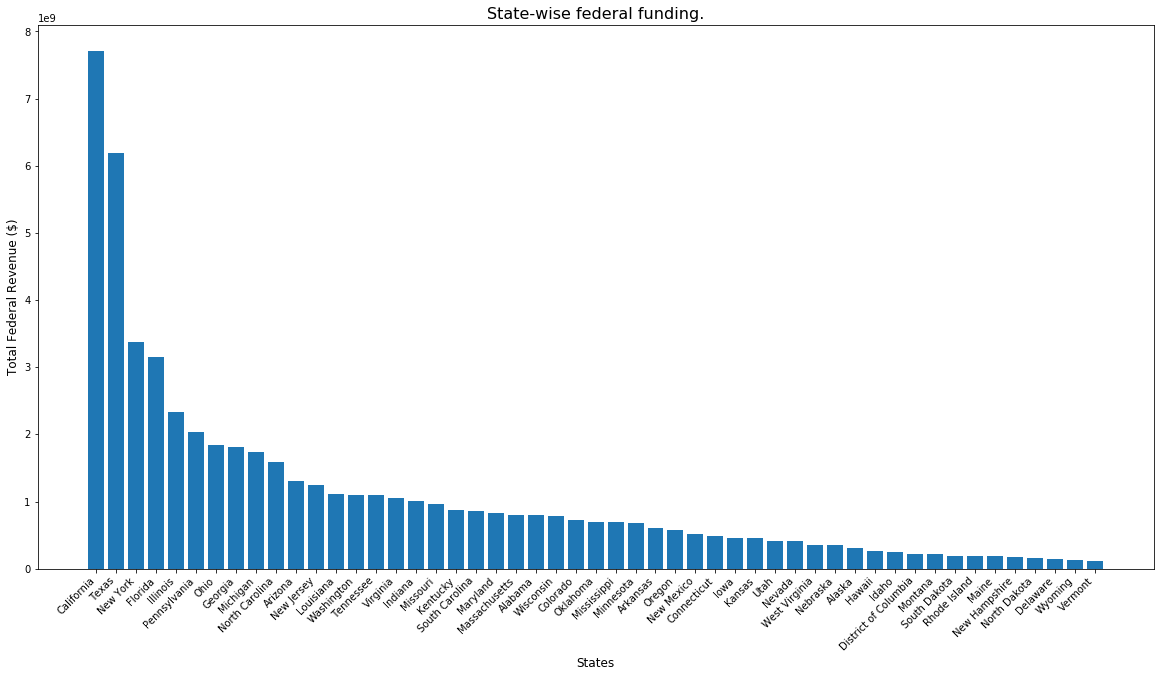

In [4]:
plt.figure(figsize=(20,10))
plt.bar(state_fiscal_data.index, state_fiscal_data.TFEDREV)
plt.xlabel('States', fontsize=12)
plt.ylabel('Total Federal Revenue ($)', fontsize=12)
_ = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light' 
)
_ = plt.title('State-wise federal funding.', fontsize = 16)

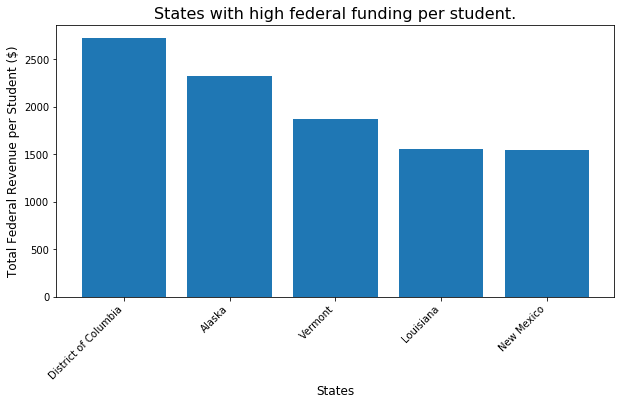

In [5]:
# state spending per student

state_fiscal_data['TFEDREVperStudent'] = state_fiscal_data['TFEDREV']/state_fiscal_data['V33']
state_fiscal_data_sorted = state_fiscal_data.sort_values(by='TFEDREVperStudent', ascending=False)

plt.figure(figsize=(10,5))
plt.bar(state_fiscal_data_sorted.head().index, state_fiscal_data_sorted.head().TFEDREVperStudent)
plt.xlabel('States', fontsize=12)
plt.ylabel('Total Federal Revenue per Student ($)', fontsize=12)
_ = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light' 
)
_ = plt.title('States with high federal funding per student.', fontsize = 16)

* We observe that District of Columbia has maximum per student Federal Funding

### Problem 2
#### Visualize the relationship between school districts’ total revenue and expenditures. Which states have the most debt per student?

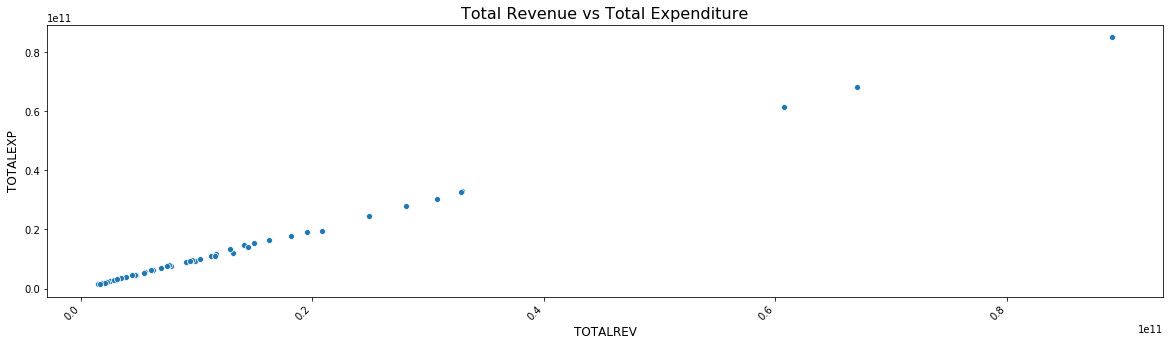

In [6]:
#state_fiscal_data[['TOTALREV','TOTALEXP','V33']]
plt.figure(figsize=(20,5))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light' 
)
plt.title("Total Revenue vs Total Expenditure", fontsize = 16)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Total Expenditure', fontsize=12)
_ = sns.scatterplot(data = state_fiscal_data, x = 'TOTALREV', y = 'TOTALEXP') 

In [7]:
sorted_debt = state_fiscal_data\
            .assign(debt_per_student = (state_fiscal_data['TOTALEXP'] - state_fiscal_data['TOTALREV'])/state_fiscal_data['V33'])


sorted_debt = sorted_debt.sort_values(by = 'debt_per_student', ascending = False)


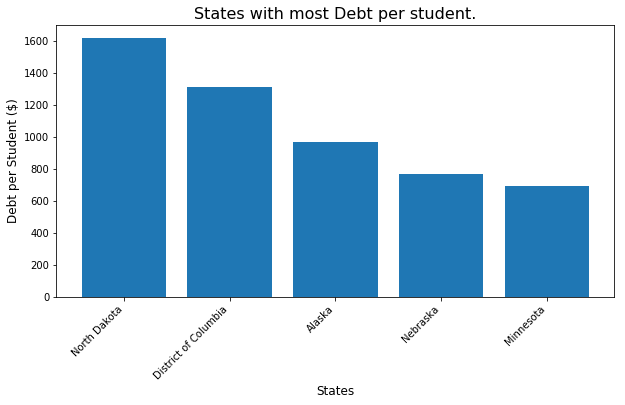

In [9]:
plt.figure(figsize=(10,5))
plt.bar(sorted_debt.head().index, sorted_debt.head().debt_per_student)
plt.xlabel('States', fontsize=12)
plt.ylabel('Debt per Student ($)', fontsize=12)
_ = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light' 
)
_ = plt.title('States with most Debt per student.', fontsize = 16)

* We observe North Dakota has maximum Debt per student

### Problem 3
#### The district-level performance metrics from EDFacts may be useful in your decision. However, to protect student privacy, the data in these datasets has been heavily “blurred” to prevent students from being identified. Therefore, most of the numeric metrics are presented as ranges in string format. In addition, censored and missing data must be imputed.
#### Write and explain a function for processing a single column of “blurred” metrics into usable numeric values. Use it to process and then visualize the distribution of a performance metric of your choice.

In [10]:
# EDFacts Data :  
# LEA level

math = pd.read_csv('./Data/math-achievement-lea-sy2015-16.csv', low_memory=False)
rla = pd.read_csv('./Data/rla-achievement-lea-sy2015-16.csv', low_memory=False)   

In [11]:
'''
## FUNCTIONS ##
preprocessing: Takes the values from the column of “blurred” metrics into usable numeric values
               * The values here are passed to the helper function that converts the messy value into range:
                       - minimum value
                       - maximum value 
               * The average of minimum and maximum value is considered as final output.       
                
findFuncValue: This function is a helper function for preprocessing.
               It converts the value to minimum and maximum value.
               
               -`PS` value is converted to 0 (for both min and max values) here.
               - Single numeric value is saved to minimum and maximum value as it is.
               - For GE or GT minimum is value itself and maximum value is 100.
               - For LE or LT minimum is 0 and maximum value is the value itself.
               
'''

def findFuncValue(value): 

    
    if re.findall("^GE|^LE|^GT|^LT", value):
        function = re.findall("^GE|^LE|^GT|^LT", value)[0]
        min_value = re.sub("^GE|^LE|^GT|^LT", "", value)
        if function in ['GE','GT']:
            max_value = 100
        
        if function in ['LE','LT']:
            max_value = min_value
            min_value = 0
               
    
    elif re.search("-", value):
        min_value = value.split("-")[0]
        max_value = value.split("-")[1]
    
    elif value == 'PS':
        min_value = '0'
        max_value = '0'
    
    else: 
        min_value = value
        max_value = value
        
    return min_value, max_value
    
def preprocessing(value):
    min_value, max_value = findFuncValue(value)
    value = (int(min_value) + int(max_value))/2
    return value
        
    

In [12]:
# imputing mean value for values hidden for privacy
math['math_proficiency'] = [preprocessing(i) for i in math.ALL_MTH00PCTPROF_1516]
math[math.math_proficiency == 0] = math.math_proficiency.mean()

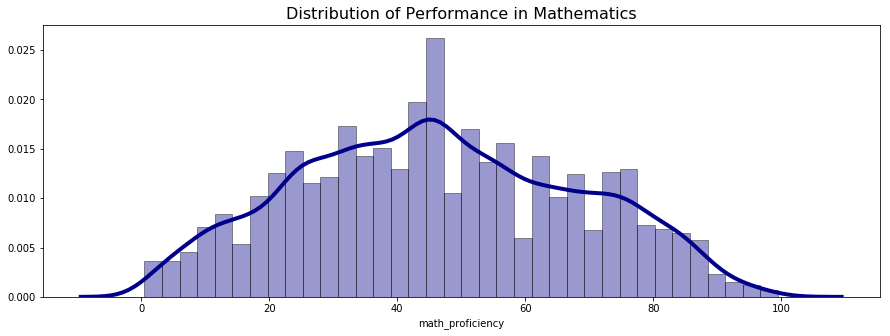

In [13]:
# Density plot shows distribution of proficiency of the students in Mathematics
plt.figure(figsize=(15,5))
plt.title('Distribution of Performance in Mathematics', fontsize = 16)
_ = sns.distplot(math.math_proficiency,hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Problem 4
#### You are tasked with cutting 15% of the U.S. federal budget currently being spent on funding school districts. How much money is this? 

In [14]:
print(f"Total Fedral Revenue is: {int(fiscal_data.TFEDREV.sum())}")
print(f"15% of Total Fedral Revenue is: {int(fiscal_data.TFEDREV.sum()*0.15)}")

Total Fedral Revenue is: 55602742000
15% of Total Fedral Revenue is: 8340411300


#### Choose which school districts will have their funding cut and how this will be done. (You should produce a table of LEA IDs and the dollar amount by which their federal funding will be cut you do not need print the entire table.)

In [15]:
LEAID_debts = fiscal_data\
      .assign(district_value_ex = fiscal_data['TOTALREV'] - fiscal_data['TOTALEXP']) \
      .assign(district_value_prop = (fiscal_data['TOTALREV'] - fiscal_data['TOTALEXP'])/fiscal_data['TOTALREV'])\
      .assign(dep_fed_rev = fiscal_data['TFEDREV']/fiscal_data['TOTALREV'])


In [16]:
cutoff_metric = LEAID_debts[(LEAID_debts.district_value_prop > 0)  & (LEAID_debts.dep_fed_rev<0.8) & (LEAID_debts.district_value_ex < LEAID_debts.TFEDREV)].sort_values(by='district_value_prop',ascending = False)



In [17]:
# % of budget to be saved from amount that can be overall saved
8340411300/cutoff_metric['district_value_ex'].sum()

0.7758224079391183

In [18]:
Cuts = cutoff_metric\
      .assign(cutAmount = cutoff_metric['district_value_ex'] * 0.7758224079391183 )\
      .assign(percTFEDREV = (cutoff_metric['district_value_ex'] * 0.7758224079391183)/ cutoff_metric['TFEDREV'] )

In [19]:
# Amount to be cut per LEAID is given by:
Cuts[['LEAID','cutAmount','percTFEDREV']]

,LEAID,cutAmount,percTFEDREV
17199,5000007,1.990760e+06,0.731091
10857,3500158,6.229854e+05,0.561754
475,0400403,1.187008e+05,0.442914
17791,5300013,7.298161e+06,0.673076
15879,4800164,5.873751e+06,0.518974
3349,1600163,6.059173e+05,0.504091
15887,4800176,3.596713e+06,0.518856
436,0400351,2.048171e+05,0.658576
9151,3004500,8.549563e+05,0.509509
17529,5099931,2.648658e+06,0.521287


In [20]:
Cuts.cutAmount.sum()

8340411300.000001

### Problem 5
#### Provide a statement for your supervisor justifying your decisions on which school districts will lose funding.

* 5732 unique LEAID's would loose their budget with minimum cutoff budget upto 0.02%. Many of the schools would be hardly affected. I have particularly targeted those districts in which schools save money each year (i.e revenue is more than expenditure) out of which those school whose dependence of federal revenue is less than 80% are selected. Hence the schools with less or no revenue outside the Federal revenue are not affected. 
* 1385  out of 5732 LEAIDs would loose less than 15% of the budget

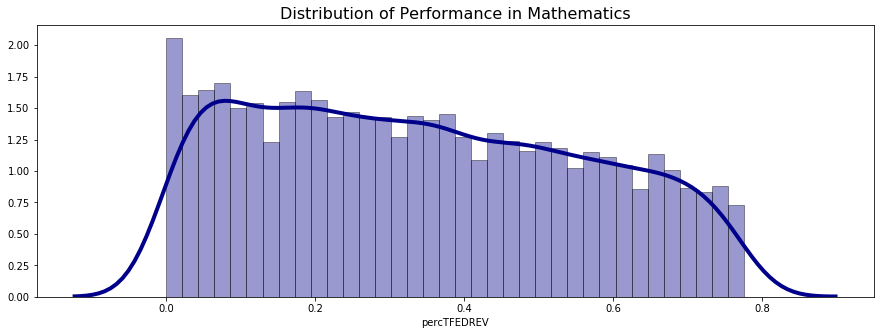

In [21]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Performance in Mathematics', fontsize = 16)
_ = sns.distplot(Cuts.percTFEDREV,hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})